<a href="https://colab.research.google.com/github/krixik-ai/krixik-docs/blob/main/docs/examples/single_module_pipelines/single_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import json
import importlib
from pathlib import Path

# demo setup - including secrets instantiation, requirements installation, and path setting
if os.getenv("COLAB_RELEASE_TAG"):
    # if running this notebook in collab - make sure to enter your secrets
    MY_API_KEY = "YOUR_API_KEY_HERE"
    MY_API_URL = "YOUR_API_URL_HERE"

    # if running this notebook on collab - install requirements and pull required subdirectories
    # install krixik python client
    !pip install krixik

    # install github clone - allows for easy cloning of subdirectories from docs repo: https://github.com/krixik-ai/krixik-docs
    !pip install github-clone

    # clone datasets
    if not Path("data").is_dir():
        !ghclone https://github.com/krixik-ai/krixik-docs/tree/main/data
    else:
        print("docs datasets already cloned!")

    # define data dir
    data_dir = "./data/"

    # create output dir
    from pathlib import Path

    Path(data_dir + "/output").mkdir(parents=True, exist_ok=True)

    # pull utilities
    if not Path("utilities").is_dir():
        !ghclone https://github.com/krixik-ai/krixik-docs/tree/main/utilities
    else:
        print("docs utilities already cloned!")
else:
    # if running local pull of docs - set paths relative to local docs structure
    # import utilities
    sys.path.append("../../../")

    # define data_dir
    data_dir = "../../../data/"

    # if running this notebook locally from krixik docs repo - load secrets from a .env placed at the base of the docs repo
    from dotenv import load_dotenv

    load_dotenv("../../../.env")

    MY_API_KEY = os.getenv("MY_API_KEY")
    MY_API_URL = os.getenv("MY_API_URL")


# load in reset
reset = importlib.import_module("utilities.reset")
reset_pipeline = reset.reset_pipeline

# import krixik and initialize it with your personal secrets
from krixik import krixik

krixik.init(api_key=MY_API_KEY, api_url=MY_API_URL)

SUCCESS: You are now authenticated.


## Single-Module Pipeline: `ocr`

This document is a walkthrough of how to assemble and use a single-module pipeline that only includes an [`ocr`](../../modules/ai_modules/ocr_module.md) module. It's divided into the following sections:

- [Pipeline Setup](#pipeline-setup)
- [Required Input Format](#required-input-format)
- [Using the Default Model](#using-the-default-model)
- [Using a Non-Default Model](#using-a-non-default-model)

### Pipeline Setup

Let's first instantiate a single-module [`ocr`](../../modules/ai_modules/ocr_module.md) pipeline.

We use the [`.create_pipeline`](../../system/pipeline_creation/create_pipeline.md) method for this, passing only the [`ocr`](../../modules/ai_modules/ocr_module.md) module name into `module_chain`.

In [3]:
# create a pipeline with a single ocr module
pipeline = krixik.create_pipeline(name="single_ocr_1", module_chain=["ocr"])

### Required Input Format

The [`ocr`](../../modules/ai_modules/ocr_module.md) module accepts `.png`, `.jpg`, and `.jpeg` images as [input](../../modules/ai_modules/ocr_module.md#inputs-and-outputs-of-the-ocr-module).

Let's take a quick look at a valid input file, and then process it.

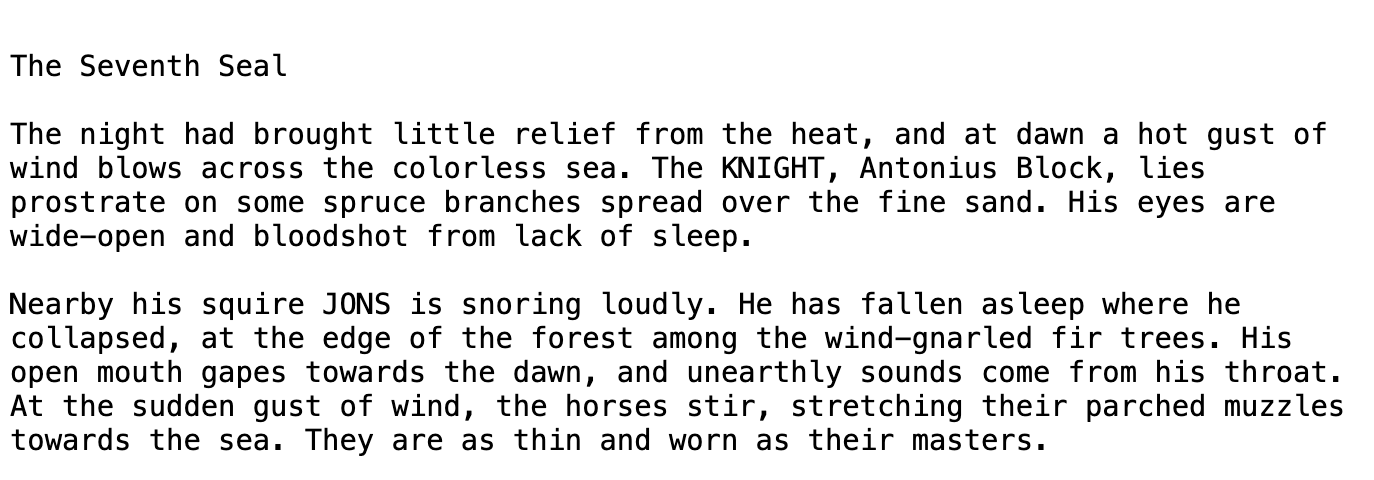

In [3]:
# examine the contents of a valid input file
from IPython.display import Image

Image(filename=data_dir + "input/seal.png")

### Using the Default Model

Let's process our test input file using the [`ocr`](../../modules/ai_modules/ocr_module.md) module's [`default model`](../../modules/ai_modules/ocr_module.md#available-models-in-the-ocr-module): [`tesseract-en`](https://github.com/tesseract-ocr/tesseract).

Given that this is the default model, we need not specify model selection through the optional [`modules`](../../system/parameters_processing_files_through_pipelines/process_method.md#selecting-models-via-the-modules-argument) argument in the [`.process`](../../system/parameters_processing_files_through_pipelines/process_method.md) method.

In [5]:
# process the file with the default model
process_output = pipeline.process(
    local_file_path=data_dir + "input/seal.png",  # the initial local filepath where the input file is stored
    local_save_directory=data_dir + "output",  # the local directory that the output file will be saved to
    expire_time=60 * 30,  # process data will be deleted from the Krixik system in 30 minutes
    wait_for_process=True,  # wait for process to complete before returning IDE control to user
    verbose=False,
)  # do not display process update printouts upon running code

The output of this process is printed below. To learn more about each component of the output, review documentation for the [`.process`](../../system/parameters_processing_files_through_pipelines/process_method.md) method.

Because the output of this particular module-model pair is a JSON file, the process output is provided in this object as well (this is only the case for JSON outputs).  Moreover, the output file itself has been saved to the location noted in the `process_output_files` key.  The `file_id` of the processed input is used as a filename prefix for the output file.

In [16]:
# load in process output from file - here we only print the text detected, and not the detection boxes, since that output is quite long
print(process_output["process_output"][0]["text"])

The Seventh Seal

The night had brought little relief from the heat, and at dawn a hot gust of
wind blows across the colorless sea. The KNIGHT, Antonius Block, lies
prostrate on some spruce branches spread over the fine sand. His eyes are
wide-open and bloodshot from lack of sleep.

Nearby his squire JONS is snoring loudly. He has fallen asleep where he
collapsed, at the edge of the forest among the wind-gnarled fir trees. His
open mouth gapes towards the dawn, and unearthly sounds come from his throat.
At the sudden gust of wind, the horses stir, stretching their parched muzzles
towards the sea. They are as thin and worn as their masters.



To confirm that everything went as it should have, let's load in the text file output from `process_output_files`:

In [25]:
# load in process output from file - here we only print the text detected, and not the detection boxes, since that output is quite long
with open(process_output["process_output_files"][0]) as f:
    print(json.load(f)[0]["text"])

The Seventh Seal

The night had brought little relief from the heat, and at dawn a hot gust of
wind blows across the colorless sea. The KNIGHT, Antonius Block, lies
prostrate on some spruce branches spread over the fine sand. His eyes are
wide-open and bloodshot from lack of sleep.

Nearby his squire JONS is snoring loudly. He has fallen asleep where he
collapsed, at the edge of the forest among the wind-gnarled fir trees. His
open mouth gapes towards the dawn, and unearthly sounds come from his throat.
At the sudden gust of wind, the horses stir, stretching their parched muzzles
towards the sea. They are as thin and worn as their masters.



### Using a Non-Default Model

To use a [non-default model](../../modules/ai_modules/ocr_module.md#available-models-in-the-ocr-module) like [`tesseract-es`](https://github.com/tesseract-ocr/tesseract), we must enter it explicitly through the [`modules`](../../system/parameters_processing_files_through_pipelines/process_method.md#selecting-models-via-the-modules-argument) argument when invoking the [`.process`](../../system/parameters_processing_files_through_pipelines/process_method.md) method.

In [26]:
# process the file with a non-default model
process_output = pipeline.process(
    local_file_path=data_dir + "input/seal.png",  # all arguments but modules are the same as above
    local_save_directory=data_dir + "output",
    expire_time=60 * 30,
    wait_for_process=True,
    verbose=False,
    modules={"ocr": {"model": "tesseract-es"}},
)  # specify a non-default model for this process

The output of this process is printed below. Although the input image has English text instead of Spanish (the model's language), all English characters are in the Spanish alphabet, so it will work well for our purposes. An English-specific OCR model might not work as well for Spanish-language text in an image.

Because the output of this particular module-model pair is a JSON file, the process output is provided in this object as well (this is only the case for JSON outputs).  Moreover, the output file itself has been saved to the location noted in the `process_output_files` key.  The `file_id` of the processed input is used as a filename prefix for the output file.

In [27]:
# load in process output from file - here we only print the text detected, and not the detection boxes, since that output is quite long
print(process_output["process_output"][0]["text"])

The Seventh Seal

The night had brought little relief from the heat, and at dawn a hot gust of
wind blows across the colorless sea. The KNIGHT, Antonius Block, lies
prostrate on some spruce branches spread over the fine sand. His eyes are
wide-open and bloodshot from lack of sleep.

Nearby his squire JONS is snoring loudly. He has fallen asleep where he
collapsed, at the edge of the forest among the wind-gnarled fir trees. His
open mouth gapes towards the dawn, and unearthly sounds come from his throat.
At the sudden gust of wind, the horses stir, stretching their parched muzzles
towards the sea. They are as thin and worn as their masters.



In [9]:
# delete all processed datapoints belonging to this pipeline
reset_pipeline(pipeline)